In [10]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler

# Load dataset
file_path = "qb_index_no_tier.csv"
df = pd.read_csv(file_path)

# Selecting relevant features for similarity analysis
features = ['nfl-comp%', 'nfl-y/a', 'nfl-ay/a', 'nfl-qbr', 'r-yds', 'r-tds']
df_filtered = df[['name'] + features].dropna()

# Normalize features
scaler = MinMaxScaler()
df_filtered[features] = scaler.fit_transform(df_filtered[features])

# Compute similarity (cosine distance)
def get_similar_players(query_player, df, features, top_n=10):
    query_vector = df[df['name'] == query_player][features].values
    all_vectors = df[features].values
    distances = cdist(all_vectors, query_vector, metric='cosine').flatten()
    df['similarity_score'] = 1 - distances  # Convert cosine distance to similarity
    return df[['name', 'similarity_score']].sort_values(by='similarity_score', ascending=False)[1:top_n+1]

# Query players
query_players = ['Patrick Mahomes', 'Lamar Jackson', 'Tom Brady']
for player in query_players:
    print(f"Top 10 players similar to {player}:")
    print(get_similar_players(player, df_filtered, features))
    print("\n")


Top 10 players similar to Patrick Mahomes:
                name  similarity_score
3         Will Levis          0.998239
20       Brock Purdy          0.997286
55    Baker Mayfield          0.996787
100    Blake Bortles          0.996566
188       Kevin Kolb          0.996496
164     Josh Freeman          0.996482
21   Trevor Lawrence          0.996338
14     Kenny Pickett          0.995433
130   Russell Wilson          0.995230
80      Paxton Lynch          0.995207


Top 10 players similar to Lamar Jackson:
                         name  similarity_score
35                Jalen Hurts          0.997575
197               Vince Young          0.997287
141          Colin Kaepernick          0.994848
51               Easton Stick          0.990337
123              B.J. Daniels          0.987769
16               Malik Willis          0.987067
101            Johnny Manziel          0.985473
85               Dak Prescott          0.984996
9    Dorian Thompson-Robinson          0.983734
54   

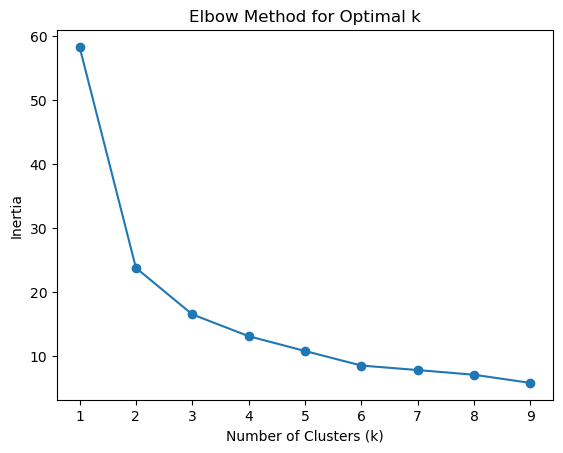

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


inertia = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_filtered[features])
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_filtered['cluster'] = kmeans.fit_predict(df_filtered[features])


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

X = df_filtered[features]
y = df_filtered['cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[56  0  0]
 [ 1 21  0]
 [ 0  1  9]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        56
           1       0.95      0.95      0.95        22
           2       1.00      0.90      0.95        10

    accuracy                           0.98        88
   macro avg       0.98      0.95      0.96        88
weighted avg       0.98      0.98      0.98        88

